In [1]:
from typing import Tuple
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

from src.get_project_data import housing_data, locale_data
pd.options.mode.chained_assignment = None  # default='warn'  # Hide SettingWithCopyWarning
warnings.filterwarnings("ignore", category=UserWarning)  # Hide matplotlib warnings

## Question
Did Covid-19 have an effect on the trends of where pending housing sales are occurring base on locale(rural, suburban, urban) in Texas overall?

## Hypothesis:
Housing trends across all of Texas see a significant change with an increase in percentage of pending housing sales in more rural or outer suburban areas while there will be a decrease in the more denser, urban areas. I expect the rate of these pending home sales to change after the pandemic lock down in Texas ends.

In [2]:
housing_df = housing_data()  # All Texas housing data by zip code
locale_df = locale_data()    # All Zip Codes and Locale (urban/rural) data

## Cleaning and Exploring Data

In [3]:
housing_df = housing_df[["date", "zipcode", "zip_name", "pending_listing_count"]]
print(housing_df.shape)
# inner join to only include zip codes that have are in both data sets
df_full = housing_df.merge(locale_df, how='inner', on="zipcode")
# A blank is 0 for pending_listing_count
df_full[["pending_listing_count"]].fillna(0, inplace=True)
print(df_full.shape)  # expect this to be smaller than original housing_df
df_full.sample(10)

(134947, 4)
(133954, 5)


,date,zipcode,zip_name,pending_listing_count,LOCALE
84036,2016-07-01,78061,"pearsall, tx",1,42
85660,2021-06-01,75217,"dallas, tx",58,11
115172,2022-07-01,77085,"houston, tx",7,11
39342,2019-10-01,79121,"amarillo, tx",15,12
99441,2020-02-01,79052,"kress, tx",1,42
124990,2022-08-01,76484,"palo pinto, tx",4,43
37505,2019-01-01,76182,"north richland hills, tx",26,21
83627,2016-11-01,75667,"laneville, tx",0,42
14471,2018-11-01,78566,"los fresnos, tx",6,41
73128,2018-01-01,76031,"cleburne, tx",20,41


In [4]:
# See amount of zip codes by Locale (Urban (1x) -> Suburban (2x) -> Town (3x) -> Rural (4x))
locale_df["LOCALE"].value_counts().sort_index()

11    275
12     56
13     13
21    148
22     14
23      3
31      6
32      9
33      3
41    320
42    712
43    430
Name: LOCALE, dtype: Int64

In [5]:
by_month_totals = df_full.groupby("date")\
                         .agg({"pending_listing_count": "sum"})\
                         .rename(columns={"pending_listing_count": "Pending Totals"})
by_month_totals.head()

,Pending Totals
date,
2016-07-01,42222
2016-08-01,40986
2016-09-01,37550
2016-10-01,34864
2016-11-01,33615


In [6]:
df_grouped = df_full.groupby(["date", "LOCALE"])\
                    .agg({"pending_listing_count": "sum"})
df_grouped["Pending %"] = df_grouped["pending_listing_count"] / by_month_totals["Pending Totals"] * 100
df_grouped.head(12)

pending_listing_count  Pending %
date       LOCALE                                  
2016-07-01 11                      11139  26.381981
           12                       1440   3.410544
           13                        210   0.497371
           21                      10467  24.790394
           22                        717   1.698167
           23                         14   0.033158
           31                        159   0.376581
           32                          6   0.014211
           41                      12823  30.370423
           42                       4862  11.515324
           43                        385   0.911847
2016-08-01 11                      10732  26.184551

## Graphs and Linear Regressions

In [7]:
# Plotting setup
land_color_list = ["#eb348c", "#fc4eda", "#e880ff",  # urban
                   "#ff9a26", "#fac852", "#fff759",  # suburban
                   "#1a2ca3", "#5477de", "#6cade6",  # town
                   "#85ed7b", "#59c24f", "#2e8f25",  # rural
                   ]
land_labels = ["Urban Large", "Urban Midsize", "Urban Small",
               "Suburban Large", "Suburban Midsize", "Suburban Small",
               "Town Fringe", "Town Distant", "Town Remote",
               "Rural Fringe", "Rural Distant", "Rural Remote",]

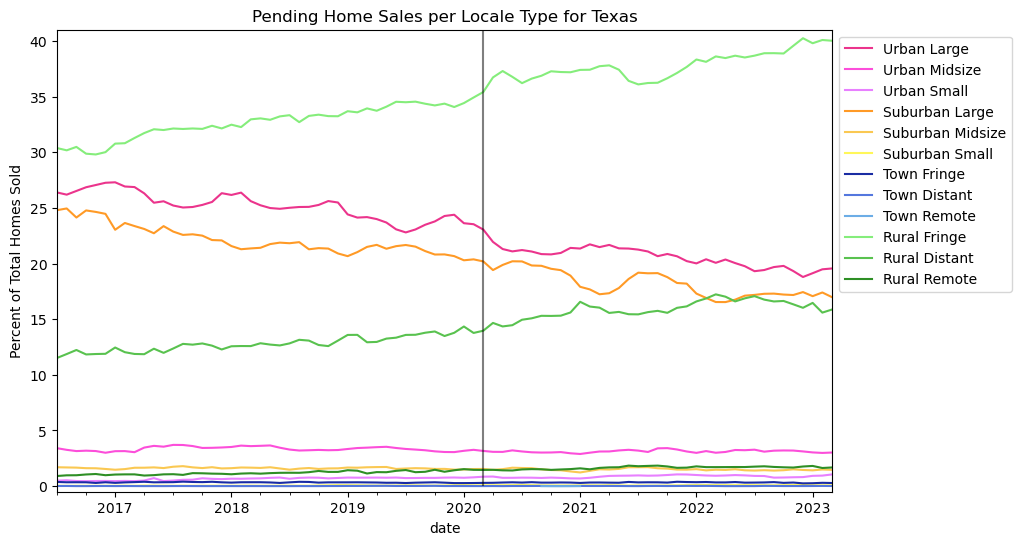

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
df_grouped.unstack().plot.line(ax=ax, y="Pending %", color=land_color_list)
ax.set(ylabel="Percent of Total Homes Sold", title="Pending Home Sales per Locale Type for Texas")
ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(pd.Timestamp(year=2020, month=3, day=13), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.set_ylim(-0.5, 41)
plt.show()

## Regressions

In [9]:
# Convert pandas timestamp to number
# since all dates in this data are at the start of the month, each month will increase the number by 1
# the first day is 2016-7-1 so that value will = 0 (pandas ordinal = 736146)
ord_test = pd.Timestamp("2016-7-1").toordinal() - 736146
ord_test2 = pd.Timestamp("2016-8-1").toordinal() - 736146
print(ord_test2)

31


In [10]:
# for regression and plotting with matplotlib, dates need to be a number, we will use pandas date ordinal
df_linear_regress_data = df_grouped.reset_index()
df_linear_regress_data["date"] = df_linear_regress_data["date"].apply(pd.Timestamp.toordinal)

# Dates
DATE_START = "2016-7-1"
DATE_END = "2023-3-1"
COVID_START_TX = "2020-3-13"
TS_COVID_START_TX = pd.Timestamp(COVID_START_TX)
# Phase 3 Reopening in Texas
COVID_AFTER = "2020-6-1"
TS_COVID_AFTER = pd.Timestamp(COVID_AFTER)

# linespace for plotting linear regressions
ls_before_covid = pd.date_range(DATE_START, COVID_START_TX, freq="MS").to_series(name="date").apply(pd.Timestamp.toordinal).reset_index(drop=True)
ls_after_covid = pd.date_range(COVID_AFTER, DATE_END, freq="MS").to_series(name="date").apply(pd.Timestamp.toordinal).reset_index(drop=True)
ls_full = pd.date_range(DATE_START, DATE_END, freq="MS").to_series(name="date").apply(pd.Timestamp.toordinal).reset_index(drop=True)

pre_covid_data = df_linear_regress_data.loc[df_linear_regress_data["date"] < TS_COVID_START_TX.toordinal(), :]
post_covid_data = df_linear_regress_data.loc[df_linear_regress_data["date"] >= TS_COVID_AFTER.toordinal(), :]
print("Pre Covid data shape:", pre_covid_data.shape)
print("During/After Covid data shape:", post_covid_data.shape)
print("Full data shape:", df_linear_regress_data.shape)

Pre Covid data shape: (495, 4)
During/After Covid data shape: (379, 4)
Full data shape: (896, 4)


In [11]:
def linear_regression_per_locale(data: pd.DataFrame, column: str, locale: int) -> Tuple[float]:
    """Gives a linear regression for the given column vs date as ordinal in data and at the given locale.

    :param data: dataFrame
    :param column: name of column
    :param locale: integer locale value
    :return: linear regression tuple
    """
    # assume data as "date" as ordinal Int and "LOCALE" as Int columns
    _data_df = data.loc[data["LOCALE"] == locale, [column, "date"]]
    _data_df = _data_df.astype(float)  # Fixes strange error AttributeError
    return st.linregress(_data_df["date"], _data_df[column])

In [12]:
def plot_regressions(ax: plt.Axes, base_data: pd.DataFrame,
                     base_color: str, locale: int, column: str,
                     pre_line_color: str, post_line_color: str,
                     useFullRegression: bool = True,
                     extendPreCovidRegression: bool = False):
    # Calculate Regressions
    regress_pre = linear_regression_per_locale(pre_covid_data, column, locale)
    regress_post = linear_regression_per_locale(post_covid_data, column, locale)
    
    # Plot regressions and base line
    ax.plot(base_data.loc[base_data["LOCALE"] == locale, "date"],
            base_data.loc[base_data["LOCALE"] == locale, column], color=base_color)
    # pre covid regression plot
    if extendPreCovidRegression:  # plot over full extent of graph
        ax.plot(ls_full, regress_pre.slope * ls_full + regress_pre.intercept, color=pre_line_color, linestyle="dotted")
    else:  # plot only up to Covid Start
        ax.plot(ls_before_covid, regress_pre.slope * ls_before_covid + regress_pre.intercept, color=pre_line_color, linestyle="dotted")
    # post covid regression plot
    ax.plot(ls_after_covid, regress_post.slope * ls_after_covid + regress_post.intercept, color=post_line_color, linestyle="dotted")

    if useFullRegression:
        regress_full = linear_regression_per_locale(df_linear_regress_data, column, locale)
        ax.plot(ls_full, regress_full.slope * ls_full + regress_full.intercept, color=base_color, linestyle="dashed", alpha=0.5)

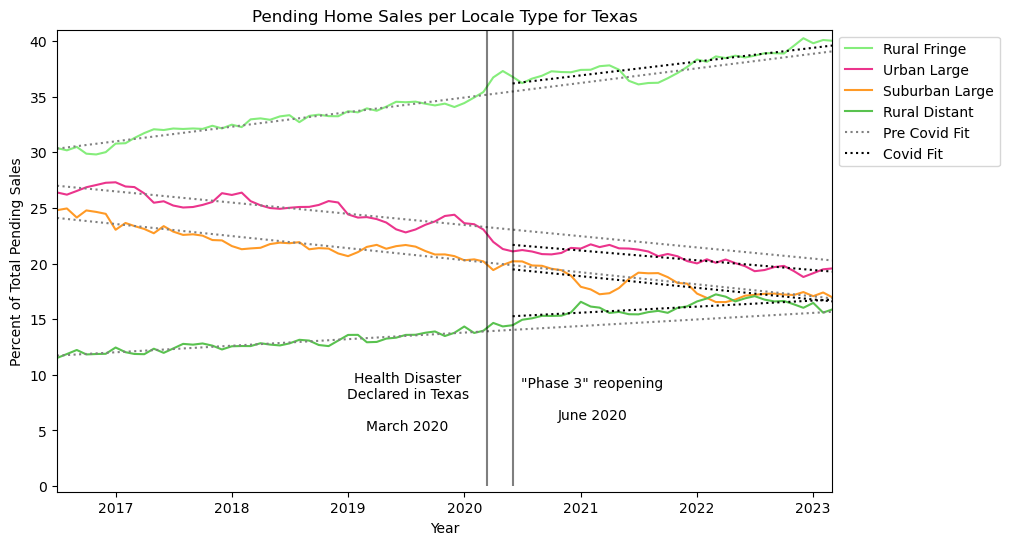

In [13]:
# Add regression lines
fig, ax = plt.subplots(figsize=(10, 6))
plot_regressions(ax, df_linear_regress_data, "#85ed7b", 41, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
plot_regressions(ax, df_linear_regress_data, "#eb348c", 11, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
plot_regressions(ax, df_linear_regress_data, "#ff9a26", 21, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
plot_regressions(ax, df_linear_regress_data, "#59c24f", 42, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
ax.set(xlabel="Year", ylabel="Percent of Total Pending Sales", title="Pending Home Sales per Locale Type for Texas")
labels_pending_home_sales_regression = ["Rural Fringe", "_Pre Covid Fit", "_Covid Fit",
                                        "Urban Large", "_Pre Covid Fit", "_Covid Fit",
                                        "Suburban Large", "_Pre Covid Fit", "_Covid Fit",
                                        "Rural Distant", "Pre Covid Fit", "Covid Fit", ]
ax.legend(labels=labels_pending_home_sales_regression, bbox_to_anchor=(1.0, 1.0))
ax.vlines(TS_COVID_START_TX.toordinal(), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.text(TS_COVID_START_TX.toordinal()-250, 5, "Health Disaster\nDeclared in Texas\n\nMarch 2020", horizontalalignment="center")
ax.vlines(TS_COVID_AFTER.toordinal(), colors='black', ymin=0, ymax=41, label="1 Year Later", alpha=.50)
ax.text(TS_COVID_AFTER.toordinal()+250, 6, '"Phase 3" reopening\n\nJune 2020', horizontalalignment="center")
ax.set_ylim(-0.5, 41)
# set ticks on year start and display as string, not ordinal
ax.set_xlim(pd.Timestamp("2016-7-1").toordinal(), pd.Timestamp("2023-3-1").toordinal())
dates = ["2017", "2018", "2019", "2020", "2021", "2022", "2023"]  # Will automatically be set to 1st day of the year
ax.set_xticks(pd.to_datetime(dates, format="%Y").to_series().apply(pd.Timestamp.toordinal), labels=dates)
plt.show()

In [14]:
def regression_summary(regress_df_column: str, calculate_tuple: Tuple[Tuple[str, int]]) -> pd.DataFrame:
    """Create a table of slopes and r-values for Pre, Post, Full linear regressions

    :param regress_df_column: column from linear_regression dataFrame to use
    :param calculate_tuple: tuple of tuples containing Locale name and Locale int
    :return: summary data frame with row for each item in `calculate_tuple`
    """
    lin_regress_summary = []
    for locale_type in calculate_tuple:
        regress_pre = linear_regression_per_locale(pre_covid_data, regress_df_column, locale_type[1])
        regress_post = linear_regression_per_locale(post_covid_data, regress_df_column, locale_type[1])
        regress_full = linear_regression_per_locale(df_linear_regress_data, regress_df_column, locale_type[1])
        line_summary = {"Pre Slope": regress_pre.slope,
                        "Pre r-value": regress_pre.rvalue,
                        "Post Slope": regress_post.slope,
                        "Post r-value": regress_post.rvalue,
                        "Full Slope": regress_full.slope,
                        "Full r-value": regress_full.rvalue,
                        "% Slope Change": (regress_post.slope - regress_pre.slope)/regress_post.slope * 100,
                        "% Intercept Change": (regress_post.intercept - regress_pre.intercept)/regress_post.intercept * 100}
        lin_regress_summary.append(line_summary)
    df_regress_summary = pd.DataFrame(lin_regress_summary, index=[item[0] for item in calculate_tuple])
    return df_regress_summary

Calculate pre and post slopes for the 4 largest locales and calculate the % Change in the slopes to see how much of a change there was.

In [15]:
locales_to_calculate = (("Rural Distant", 42), ("Rural Fringe", 41), ("Suburban Large", 21), ("Urban Large", 11))
regression_summary("Pending %", locales_to_calculate)

,Pre Slope,Pre r-value,Post Slope,Post r-value,Full Slope,Full r-value,% Slope Change,% Intercept Change
Rural Distant,0.001616,0.932290,0.001488,0.660684,0.002299,0.959896,-8.562923,-8.796820
Rural Fringe,0.003590,0.966711,0.003393,0.844637,0.003958,0.979937,-5.801365,-5.915648
Suburban Large,-0.002967,-0.910687,-0.002864,-0.774975,-0.003153,-0.965014,-3.614538,-3.599032
Urban Large,-0.002757,-0.885360,-0.002394,-0.875399,-0.003445,-0.970166,-15.160422,-15.053007


## Conclusion

Looking at the calculated values, the slopes have a small percentage change. From this we can conclude that overall in Texas, there was **no significant change** in the rates of people buying more rural housing rather than dense suburban or urban housing. All four of the largest locales shown above continued on with the same trend as before the pandemic with only small changes.

| Locale         | Pre Covid Slope | Covid Slope |  % Change  |
|:---------------|----------------:|------------:|-----------:|
| Rural Distant  |  0.001616       |   0.001488  | -8.562923  |
| Rural Fringe   |  0.003590       |   0.003393  | -5.801365  |
| Suburban Large | -0.002967       |  -0.002864  | -3.614538  |
| Urban Large    | -0.002757       |  -0.002394  | -15.160422 |

The hypothesis that there would be noticeable changes in the rate of pending home sales by locale type in Texas overall is false.

Potential improvements to this analysis would be to have a finer data set instead of zip codes such as census blocks. However, this data seems like it may be hard to come by without having the exact address of every home sold in Texas over the years which would be impossible to get as there is no home sale reporting requirement. The local real estate organizations and other sources may have better, more precise data, but it is behind paywalls.

Another potential change would be to look at data across all zip codes independently and see if certain regions have seen a change in growth rate after the start of the pandemic.